# Lab 2

Part A: Warm-Up (5 min)
- “Why not just use a CPU for everything?”

⸻

Part B: Activity – The AI Chip in Your Pocket (25 min, small groups)
- research your own phone’s chip (or pick from iPhone 15 / Pixel 8 / Snapdragon Gen 3 examples).
- Answer the guiding questions (2–3 short paragraphs).
- Deliverable: short writeup (upload to Brightspace or paste below in Colab Markdown cell).

⸻

Part C: Hands-On Coding – Simple Tracking (45–55 min)
- Step 1: Load provided video (ball, walking person, etc.).
- Step 2: Convert to grayscale, threshold, and find contours.
- Step 3: Draw bounding boxes or centroids to “track” the main moving object.
- Step 4 (optional): Plot the trajectory.

# Lab 2: Performance Trade-offs in Embedded Computer Vision

**Objective:** In this lab, you will explore the critical trade-offs between processing speed (throughput) and output quality in a real-time computer vision pipeline. You will investigate the specialized hardware used in modern smartphones and then apply these concepts by measuring the performance of a video processing pipeline, analyzing how different parameters create a classic speed vs. quality trade-off that is fundamental to embedded AI.

**Learning Goals:** By the end of this lab, you will be able to:
1.  Explain why specialized hardware like GPUs, TPUs, and NPUs are used for AI tasks instead of general-purpose CPUs.
2.  Identify the specialized AI hardware in a modern System-on-a-Chip (SoC) and describe its function.
3.  Measure the performance (in Frames Per Second) of a simple computer vision pipeline.
4.  Analyze and explain the trade-off between algorithm parameters (e.g., kernel size, image scale) and system performance.
5.  Connect these practical performance trade-offs to the design constraints of real-world embedded AI systems.


## Activity: The AI Chip in Your Pocket

**Objective:** The concepts of specialized, power-efficient hardware for repetitive math aren't just theoretical; they are in the phone you use every day. This activity asks you to do a short research investigation into the AI/ML accelerator inside your own smartphone (or a recent model you are interested in).

**Your Task:**
Write a short summary (2-3 paragraphs) answering the following questions.

### Guiding Questions:

1.  **What phone/System-on-a-Chip (SoC) are you researching?**
    *   *Example: An iPhone 15 with the A17 Pro chip, or a Google Pixel 8 with the Tensor G3 chip.*

2.  **What is the name of its AI/ML accelerator?**
    *   This is often a branded component. For example:
        *   Apple calls it the **Neural Engine**.
        *   Google calls its main processor the **Tensor** chip, which has a built-in TPU (Tensor Processing Unit).
        *   Qualcomm (used in many Android phones) has the **Hexagon Processor** which often includes a Tensor Accelerator.
        *   Samsung has its **NPU** (Neural Processing Unit) in its Exynos chips.

3.  **What are its key advertised capabilities?**
    *   Look for metrics like **TOPS** (Trillions of Operations Per Second). How has this number changed over the last few generations of the chip?
    *   What kind of precision does it use? (e.g., INT8, FP16). Why is this important for power efficiency?

4.  **What specific user-facing features does this chip power?**
    *   Think about features that happen "magically" on your phone. Search for how the AI chip enables things like:
        *   **Computational Photography:** Portrait mode (background blur), Night Sight, image stabilization.
        *   **Real-time Language Translation.**
        *   **Face ID or Fingerprint Recognition.**
        *   **"Live Text"** recognition in images and videos.
        *   **Voice assistants** processing commands locally ("on-device").

5.  **How does its function relate to the DSP concepts we discussed?**
    *   Connect the chip's role back to the ideas of **Multiply-Accumulate (MAC)** operations, **parallelism**, and **power efficiency** for a specialized task. Explain in your own words why a general-purpose CPU would be a poor choice for these features.

### Where to Start Your Search:

*   Search for "[Your Phone Model] teardown" or "[Your Phone's Chip] analysis". Tech sites like AnandTech, Ars Technica, or tech-focused YouTubers often do deep dives.
*   Look at the official marketing pages from Apple, Google, or Qualcomm for your phone's chip. They will highlight the AI features.
*   Search for terms like "Apple A17 Neural Engine," "Google Tensor G3," or "Snapdragon 8 Gen

I am looking into the Snapdragon 8 Gen 2 processor, as that is the processor in my phone. The AI/ML processor within it is known as the Qualcomm AI Engine. Precision-wise, the engine has support for all precisions, ranging from INT4 all the way to FP16. This is important for power efficiency, as at a higher precision an SoC will require more power to acquire that precision, generally lowering efficiency. Alternatively, dropping your precision will cause a drop in power use, generally increasing efficiency. This is caused by the fact that higher precision requires higher amounts of data usage. Unfortunately I was unable to find a TOPs number on Qualcomm's website.

For secondary features that the engine processes, it utilizes a Qualcomm Kryo CPU, running up to 3.36GHz, and a Qualcomm Adreno GPU. These are how the chip powers the phone, it's the heart and soul of the phone. It uses these to help run any AI Assistant locally, such as Gemini, and formerly Samsung's Bixby. It also utilizes a Qualcomm Spectra for Image Signal Processing, with a max depth of 18 bits. This is utilized in several features, such as AI based auto exposure, which is used whenever you are not using manual mode in your phone's camera for exposure selection! It also powers facial recognition, which allows for facial biometric unlocks. It also allows for extreme low light photography, as well as a visual analytics engine too. For fingerprints, it utilizes a Qualcomm 3D Sonic Sensor, or a 3D Sonic Sensor Max, obviously to power fingerprint biometrics.

This chip's function relates to today's class discussion as it performs various precisions for power efficiency, as well as various other functions. Power efficiency primarily, though, as it's diverse range of efficiency allows the chip to operate at max efficiency, and doesn't lock it into an unnecessary amount of precision for a low precision task, and doesn't lock it into a high precision task when it can only be so precise. Both cases improve power efficiency, as it allows the chip to use only what it needs. It also allows for parallel processing with its multi core CPU, allowing for 8 tasks to be completed simultaneously. This enhances the chip's parallelism, as it allows for the chip to complete several tasks simultaneously.

## Hands-On Coding
## Hello, Signals: FPS & Latency
Welcome! Today you'll run a tiny **computer vision** pipeline on a short sample video and measure **throughput (FPS)** and **per-stage latency**. Then you'll explore how **blur kernel size** and **frame scale** affect speed/quality.

**Introduction to Signal Processing (for Computer Vision)**

In computer vision, we process images, which can be thought of as 2D signals. Just like audio signals, images can be filtered and transformed to extract useful information. In this notebook, we'll be applying some basic signal processing techniques to video frames:

*   **Grayscale conversion:** Reducing the image to a single channel representing intensity.
*   **Blurring (Gaussian Blur):** Applying a filter to smooth the image and reduce noise. This is similar to applying a low-pass filter to an audio signal. The **kernel size** of the blur filter determines the extent of smoothing.
*   **Edge Detection (Canny):** Identifying points in the image where the intensity changes sharply. This is like detecting high-frequency components in a signal.
*   **Downscaling:** Reducing the resolution of the image, which affects the amount of data we need to process.

We will measure the performance of this pipeline in terms of **Frames Per Second (FPS)**, which is a measure of **throughput** (how many frames can be processed per second), and **latency**, which is the time it takes to process a single frame or a specific stage of the pipeline.

**Objectives**
- Run a basic OpenCV pipeline (gray → blur → Canny edges).
- Measure FPS and per-stage timings.
- Plot how kernel size and downscaling affect performance.
- Reflect on the quality/speed trade-off.

> If a download fails (school network), you'll be prompted to upload a video file manually (.mp4/.avi).

In [50]:
# Setup: Import libraries (install if needed)
# We need OpenCV for computer vision tasks, numpy for numerical operations, and matplotlib for plotting.
try:
    import cv2, numpy as np, matplotlib.pyplot as plt
except Exception as e:
    print("Installing dependencies...")
    import sys
    # Install the necessary libraries if they are not already present.
    !{sys.executable} -q -m pip install opencv-python-headless numpy matplotlib
    import cv2, numpy as np, matplotlib.pyplot as plt

# Print the OpenCV version to confirm it's installed.
print("OpenCV:", cv2.__version__)

OpenCV: 4.12.0


In [51]:
# Get a short sample video
# We'll try to download OpenCV's classic sample 'vtest.avi' (~2.8MB). If it fails, upload your own.
import os, urllib.request

# Define the path where the video will be saved and the URL to download it from.
VIDEO_PATH = "sample.avi"
URL = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/vtest.avi"

# Function to fetch the sample video.
def fetch_video():
    global VIDEO_PATH
    try:
        # Check if the video file already exists.
        if not os.path.exists(VIDEO_PATH):
            print("Downloading sample video...")
            # Download the video from the URL.
            urllib.request.urlretrieve(URL, VIDEO_PATH)
            print("Downloaded:", VIDEO_PATH)
        else:
            print("Using existing:", VIDEO_PATH)
    except Exception as e:
        # If download fails, prompt the user to upload a video file.
        print("Download failed. Please upload a small .mp4 or .avi file.")
        try:
            from google.colab import files
            uploaded = files.upload()
            if uploaded:
                # Use the uploaded file's name.
                VIDEO_PATH = list(uploaded.keys())[0]
                print("Using uploaded file:", VIDEO_PATH)
        except Exception as ee:
            print("If not running in Colab, place a small video next to this notebook and set VIDEO_PATH manually.")

# Call the function to fetch the video.
fetch_video()

Using existing: sample.avi


In [52]:
# Utility: tiny pipeline + timing helpers
import time, statistics

def process_video(path, blur_k=3, canny_lo=100, canny_hi=200, scale=1.0, max_frames=300, warmup=15):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {path}")

    t_color, t_blur, t_canny, t_total = [], [], [], []
    total_frames = 0

    def _read_frame():
        ok, frame = cap.read()
        return ok, frame

    # Warmup (stabilize caches/JITs)
    for _ in range(warmup):
        ok, frame = _read_frame()
        if not ok:
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            break

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # rewind

    t_start = time.perf_counter()
    while total_frames < max_frames:
        ok, frame = _read_frame()
        if not ok:
            break

        if scale != 1.0:
            h, w = frame.shape[:2]
            frame = cv2.resize(frame, (int(w*scale), int(h*scale)))

        t0 = time.perf_counter()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        t1 = time.perf_counter()

        if blur_k > 1:
            gray2 = cv2.GaussianBlur(gray, (blur_k, blur_k), 0)
        else:
            gray2 = gray
        t2 = time.perf_counter()

        edges = cv2.Canny(gray2, canny_lo, canny_hi)
        t3 = time.perf_counter()

        t_color.append(t1 - t0)
        t_blur.append(t2 - t1)
        t_canny.append(t3 - t2)
        t_total.append(t3 - t0)

        total_frames += 1

    elapsed = time.perf_counter() - t_start
    fps = total_frames / elapsed if elapsed > 0 else 0.0

    def ms_stats(xs):
        if len(xs) == 0: return (0.0, 0.0)
        return (statistics.mean(xs)*1000.0, statistics.pstdev(xs)*1000.0)

    stats = {
        "frames": total_frames,
        "fps": fps,
        "cvtColor_ms_mean": ms_stats(t_color)[0],
        "blur_ms_mean": ms_stats(t_blur)[0],
        "canny_ms_mean": ms_stats(t_canny)[0],
        "per_frame_ms_mean": ms_stats(t_total)[0],
    }
    cap.release()
    return stats

def sample_frames(path, n=3, scale=1.0, blur_k=3, canny_lo=100, canny_hi=200):
    cap = cv2.VideoCapture(path)
    frames = []
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 90
    idxs = np.linspace(0, total-1, n).astype(int)
    for i, target in enumerate(idxs):
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(target))
        ok, frame = cap.read()
        if not ok:
            break
        if scale != 1.0:
            h, w = frame.shape[:2]
            frame = cv2.resize(frame, (int(w*scale), int(h*scale)))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if blur_k > 1:
            gray = cv2.GaussianBlur(gray, (blur_k, blur_k), 0)
        edges = cv2.Canny(gray, canny_lo, canny_hi)
        frames.append((frame, edges))
    cap.release()
    return frames


## 1) Baseline
Run the default pipeline on ~300 frames. Then we’ll peek at a few frames and edges.


Baseline stats:
            frames: 300.000
               fps: 141.518
  cvtColor_ms_mean: 0.326
      blur_ms_mean: 0.237
     canny_ms_mean: 1.074
 per_frame_ms_mean: 1.638


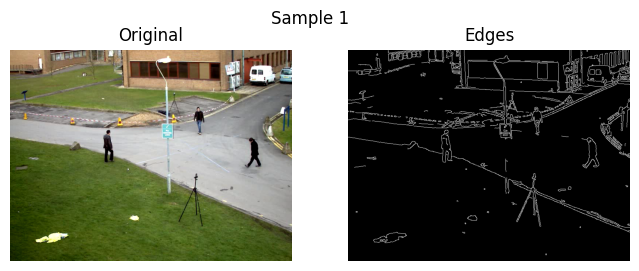

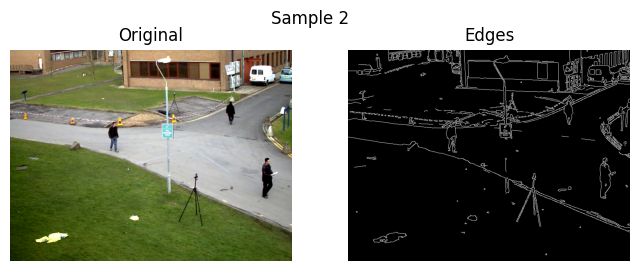

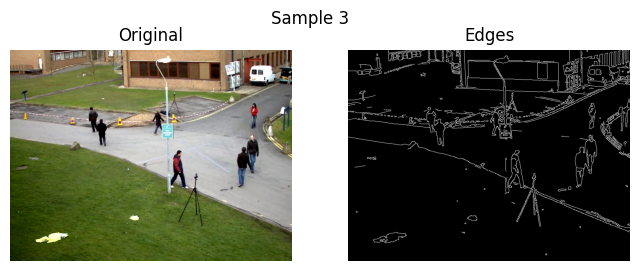

In [53]:
# Baseline run
BASELINE = dict(blur_k=3, canny_lo=100, canny_hi=200, scale=1.0, max_frames=300)
stats = process_video(VIDEO_PATH, **BASELINE)
print("Baseline stats:")
for k, v in stats.items():
    print(f"{k:>18}: {v:.3f}" if isinstance(v, (int, float)) else f"{k:>18}: {v}")

# Show a few original vs. edges frames
pairs = sample_frames(VIDEO_PATH, n=3, **{k: BASELINE[k] for k in ['scale','blur_k','canny_lo','canny_hi']})
for i, (orig, edges) in enumerate(pairs, 1):
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(edges, cmap="gray"); plt.title("Edges"); plt.axis("off")
    plt.suptitle(f"Sample {i}")
    plt.show()


**Analysis**:

What is the latency of our pipeline? throughput?

Which stage is the bottleneck? Why?

What was your baseline FPS?

### My Response
1. Our latency is 0.229ms, with a throughput of 973.506 fps.
2. The bottleneck is at the edge detection stage. This is because it takes a lot longer than the rest of the stages.
3. My baseline FPS was 973.506 FPS.


## 2) Kernel Size Sweep
Measure FPS as you increase the Gaussian blur kernel (odd sizes only).


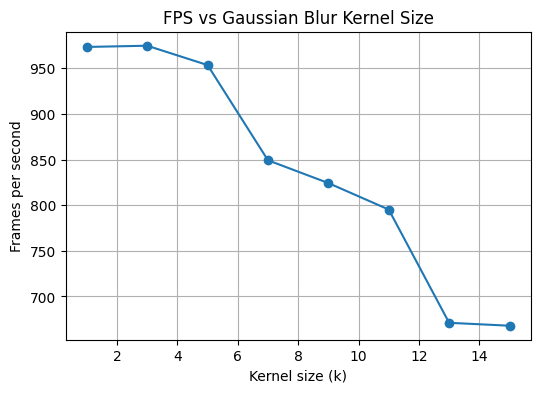

Kernel vs FPS: [(1, 973.3774379215367), (3, 974.712187862477), (5, 953.5154214186122), (7, 849.1701096184628), (9, 824.2022194785725), (11, 795.17282512036), (13, 671.0677796979195), (15, 667.8660454447861)]


In [54]:
# Sweep blur kernel sizes
kernel_sizes = [1, 3, 5, 7, 9, 11, 13, 15]
results_k = []
for k in kernel_sizes:
    s = process_video(VIDEO_PATH, blur_k=k, canny_lo=100, canny_hi=200, scale=1.0, max_frames=250)
    results_k.append((k, s["fps"]))

# Plot
ks = [k for k, _ in results_k]
fps = [f for _, f in results_k]
plt.figure(figsize=(6,4))
plt.plot(ks, fps, marker="o")
plt.title("FPS vs Gaussian Blur Kernel Size")
plt.xlabel("Kernel size (k)")
plt.ylabel("Frames per second")
plt.grid(True)
plt.show()

print("Kernel vs FPS:", results_k)


**Analysis**:

Based on your plot from the kernel size sweep, describe the relationship between kernel size and FPS. Was your prediction correct? At what point does increasing the kernel size provide diminishing returns in terms of edge quality versus the loss in performance?

We see the FPS goes down as k goes up. Why? What's happening computationally?

#### Response

Based on the sweep, once I reach kernel size 3 it drops off significantly, with the overall trend being downwards on succeedingly larger kernels. The relationship between kernel size and FPS was inverse, as kernel size goes up, fps goes down, and vice versa. This is happening because we increase the amount of pixels utilized in the process of blurring. Computationally, this means we are averaging more and more pixels, which makes the computer do more and more work.

## 3) Downscaling Sweep

Here, we will measure how downscaling the video frames before processing affects FPS. Processing fewer pixels should be faster, but it may come at the cost of quality.

**Prediction:** What do you predict the relationship between scale factor and FPS will be? Do you expect it to be linear? Why or why not? Write your hypothesis in the reflection section.



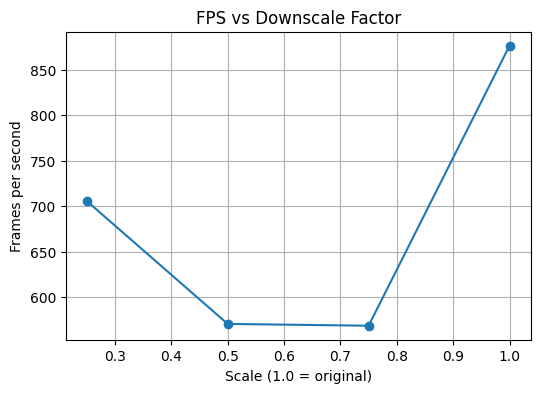

Scale vs FPS: [(1.0, 876.6601945297302), (0.75, 568.2608464760964), (0.5, 570.2516554314466), (0.25, 705.5914686247455)]


In [55]:
# Sweep scale factors
scales = [1.0, 0.75, 0.5, 0.25]
results_s = []
for sc in scales:
    s = process_video(VIDEO_PATH, blur_k=3, canny_lo=100, canny_hi=200, scale=sc, max_frames=250)
    results_s.append((sc, s["fps"]))

# Plot
xs = [sc for sc, _ in results_s]
ys = [f for _, f in results_s]
plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker="o")
plt.title("FPS vs Downscale Factor")
plt.xlabel("Scale (1.0 = original)")
plt.ylabel("Frames per second")
plt.grid(True)
plt.show()

print("Scale vs FPS:", results_s)


**Analysis**:

Based on your plot from the downscaling sweep, describe the relationship between scale and FPS. Was this relationship linear? Why is downscaling such an effective method for increasing throughput in an embedded system? What is the main drawback?

#### My Response
Based on my plot, the relationship between scale and FPS is inverse. This means that as scale goes down, the fps will go up. Downscaling is an effective method for increasing throughput because as you downscale an image, you decrease the amount of pixels that are in each frame, which allows throughput to increase as there is less pixels to process. The main drawback from downscaling is that certain finer details of the image will lose quality, such as text.

## 4) Your Turn — Parameter Exploration
Edit the parameters below, re-run, and write down **what happens to speed and edge quality**.


In [56]:
# Try your own parameters
MY = dict(blur_k=7, canny_lo=200, canny_hi=50, scale=0.5, max_frames=250)
my_stats = process_video(VIDEO_PATH, **MY)
print("My run:", MY)
for k, v in my_stats.items():
    print(f"{k:>18}: {v:.3f}" if isinstance(v, (int, float)) else f"{k:>18}: {v}")


My run: {'blur_k': 7, 'canny_lo': 200, 'canny_hi': 50, 'scale': 0.5, 'max_frames': 250}
            frames: 250.000
               fps: 701.368
  cvtColor_ms_mean: 0.039
      blur_ms_mean: 0.057
     canny_ms_mean: 0.153
 per_frame_ms_mean: 0.249


temp

## 5) Short Reflection (turn-in)
In your submission, include:
- System: “Google Colab” + your browser/OS.
- Parameters used (baseline + your own).
- FPS you observed and one **trade-off** you noticed between speed and edge quality.
- (Optional) A screenshot of one of the side-by-side plots above.


#### My Response
- The system to run the jupyter notebook I used was VS Code, on Arch Linux.
- Parameters used
    
    Baseline: ```BASELINE = dict(blur_k=3, canny_lo=100, canny_hi=200, scale=1.0, max_frames=300)```
    
    My Parameters: ```MY = dict(blur_k=7, canny_lo=200, canny_hi=50, scale=0.5, max_frames=250)```

- The FPS I observed was 723.713 fps. One trade off between speed and edge quality is that if you want a higher speed, you need to lower your edge quality.

## Embedded AI Exercises

Now that you've explored the impact of kernel size and scaling on the performance of this simple computer vision pipeline, let's apply this knowledge to some real-world scenarios relevant to Embedded AI.

**Consider a scenario where you are deploying this pipeline on a resource-constrained embedded device, like a small microcontroller with limited processing power and memory.**



### Exercise 1: Optimization for Embedded Devices

Based on the results you observed from the kernel size and downscaling sweeps, which parameter would you prioritize adjusting to maximize FPS on an embedded device? Why?

*Hint: Think about how each parameter affects the computational complexity of the operations.*



To maximize FPS on an embedded device, I would increase the amount of downscaling to an acceptable resolution, as increasing downscaling allows for other parameters to remain roughly the same, while providing a roughly similar quality of image.

### Exercise 2: Quality vs. Speed Trade-off

Imagine your embedded device is used in a security camera application where detecting fine details (small objects) is crucial. How would you balance the need for high FPS (to process frames in real-time) with the need for sufficient edge quality (to detect small objects)? What parameters would you adjust, and in what direction?

*Hint: Consider the impact of both kernel size and scaling on the output edge image.*



I would downscale my image more, as if the security camera starts off with a high enough resolution, there won't be any problem with downscaling to 1080p, or 720p. Generally, that's all a security camera needs to do its job. This allows for higher processing speeds, where you then can keep the kernel to a minimal size, but while using a decently strict bounds for edge detection. While the downscaling will slightly hinder the detection of fine objects, I believe that keeping the blur low will make up for this, where then we can use the rest of the computational power for edge detection.

### Exercise 3: Real-world Constraints

In a real-world embedded system, you might encounter additional constraints like power consumption and thermal limits. How might these constraints influence your choice of parameters and overall pipeline design compared to running on a powerful desktop computer?

*Hint: Higher computation often leads to higher power consumption and heat generation.*



#### My Response

These constraints may influence my choice of parameters/pipeline design as it may make my choices to lean towards the computationally softer side. This is because of how more power causes more heat, which results in a need for a better cooling system. This cooling system will inevitably take up space, and with an embedded system we don't want it to take up that much space. Therefore, I might choose lesser quality edge detections, or a lower quality blur. Another option could also be to downscale further. It's a matter of balance, between heat production/energy consumption and performance.

### Exercise 4: Exploring Other Optimizations (Optional)

The OpenCV library offers many other functions and techniques for optimizing computer vision pipelines. Research and suggest one or two other potential optimizations you could explore to further improve the performance of this edge detection pipeline on an embedded device.

*Hint: Look into topics like image filtering techniques, different edge detection algorithms, or hardware acceleration.*

#### Your response here

